# Proyecto 04 - Informe final - Emanuel Caneva

### Continuación Proyecto 3

**Como punto de partida elegimos el proyecto 3, el objetivo planteado es desarrollar los items mencionados para investigar o probar en el proyecto de series de tiempo, intentamos mejorar los resultados implementando Prophet y XG Boost, para este último agregamos información sobre tipo de vehículo, forma de pago, sentido, día de la semana, de esta manera podremos comprobar si mejoran o no las predicciones de acuerdo a lo expresado en el punto opcional del Proyecto 3, tal como se mencionó en el mismo lo esperado sería mejorar el resultado mas que nada con Prophet, ya que es específico para trabajar con series de tiempo.**


Importamos las librerías necesarias

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data types
import datetime

# statistics
from statsmodels.graphics.tsaplots import plot_acf

# prophet by Facebook
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

#Error metrics
from sklearn.metrics import mean_squared_error

#HyperParameter optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

#Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# machine learning: XGB
import xgboost as xgb
from xgboost.sklearn import XGBRegressor # wrapper

Cargamos los datasets

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Para poder comparar con los resultados obtenidos en el proyecto 3 usamos la misma información, por lo tanto filtramos la estación **Illia** y la forma de pago **Efectivo**


In [3]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

In [4]:
dataset.shape

(238869, 10)

In [5]:
dataset.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


Agregamos la columna fecha

In [6]:
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [7]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [8]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [9]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


### Desarrollo de XG Boost incorporando variables tipo de vehículo, forma de pago, sentido, día de la semana etc. ###

Copiamos el dataset del punto anteior en uno nuevo para luego aplicar tranformación de datos

In [10]:
dataset_proy4=dataset.copy()
dataset_proy4

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


In [11]:
dataset_proy4.describe().round(2)

,cantidad_pasos
count,238869.00
mean,200.38
std,403.25
min,1.00
25%,2.00
50%,11.00
75%,104.00
max,2416.00


In [12]:
dataset_proy4 = dataset_proy4.set_index('fecha')
dataset_proy4

,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1
2017-01-01 00:00:00,Domingo,Provincia,Liviano,9
2017-01-01 00:00:00,Domingo,Provincia,Liviano,644
2017-01-01 00:00:00,Domingo,Provincia,Pesado,6
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1
...,...,...,...,...
2019-12-31 22:00:00,Martes,Provincia,Liviano,556
2019-12-31 22:00:00,Martes,Provincia,Pesado,1
2019-12-31 22:00:00,Martes,Centro,Liviano,580


A partir de la fecha agregaos el año, mes y día

In [13]:
dataset_proy4['Anio'] = dataset_proy4.index.year
dataset_proy4['Nro_Mes'] = dataset_proy4.index.month
dataset_proy4['Nro_dia'] = dataset_proy4.index.day
dataset_proy4

,dia,sentido,tipo_vehiculo,cantidad_pasos,Anio,Nro_Mes,Nro_dia
fecha,,,,,,,
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1,2017,1,1
2017-01-01 00:00:00,Domingo,Provincia,Liviano,9,2017,1,1
2017-01-01 00:00:00,Domingo,Provincia,Liviano,644,2017,1,1
2017-01-01 00:00:00,Domingo,Provincia,Pesado,6,2017,1,1
2017-01-01 00:00:00,Domingo,Provincia,Pesado,1,2017,1,1
...,...,...,...,...,...,...,...
2019-12-31 22:00:00,Martes,Provincia,Liviano,556,2019,12,31
2019-12-31 22:00:00,Martes,Provincia,Pesado,1,2019,12,31
2019-12-31 22:00:00,Martes,Centro,Liviano,580,2019,12,31


Comprobamos si hay valores nulos

In [14]:
dataset_proy4.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
Anio              0
Nro_Mes           0
Nro_dia           0
dtype: int64

Graficamos la variable cantidad de pasos para ver su distribución, outliers etc.

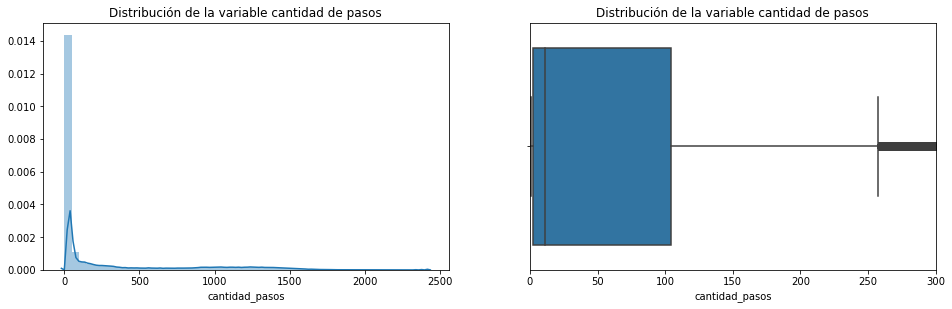

In [15]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_proy4['cantidad_pasos'])
plt.title('Distribución de la variable cantidad de pasos')

plt.subplot(2,2,2)
sns.boxplot(dataset_proy4['cantidad_pasos'])    
plt.title('Distribución de la variable cantidad de pasos')
plt.xlim(0,300)

plt.show()

Creamos la función para buscar los outliers y llamamos a la misma para identificarlos y luego interpolar

In [16]:
def eliminar_outliers(dataset,var):
    q25,q75 = np.percentile(dataset[var], [25,75])
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = np.logical_or(dataset[var] < minimo, dataset[var] > maximo)
    return mascara_outliers

In [17]:
mascara_outliers=eliminar_outliers(dataset_proy4,'cantidad_pasos')
mascara_outliers.sum()

46215

In [18]:
dataset_proy4.cantidad_pasos[mascara_outliers]=np.nan
print(dataset_proy4.isna().sum())
dataset_proy4 = dataset_proy4.interpolate(method='time')
print(dataset_proy4.isna().sum())

dia                   0
sentido               0
tipo_vehiculo         0
cantidad_pasos    46215
Anio                  0
Nro_Mes               0
Nro_dia               0
dtype: int64
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
Anio              0
Nro_Mes           0
Nro_dia           0
dtype: int64


Graficamos nuevamente para ver como queda la distribución sin los outliers

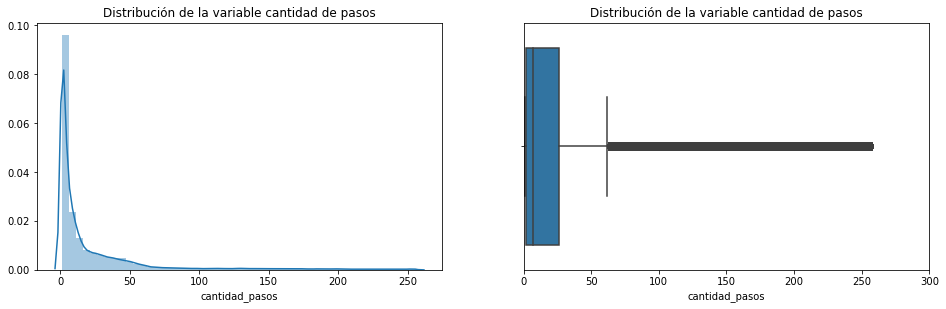

In [19]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_proy4['cantidad_pasos'])
plt.title('Distribución de la variable cantidad de pasos')

plt.subplot(2,2,2)
sns.boxplot(dataset_proy4['cantidad_pasos'])    
plt.title('Distribución de la variable cantidad de pasos')
plt.xlim(0,300)

plt.show()

In [20]:
dataset_proy4.cantidad_pasos.describe().round(2)

count    238869.00
mean         24.50
std          44.14
min           1.00
25%           2.00
50%           7.00
75%          26.00
max         257.00
Name: cantidad_pasos, dtype: float64

Tranformamos atributos categóricos en información (Encoding), para las variables tipo_vehiculo y sentido usaremos OneHotEncoder ya que estas no tienen un orden, en cambio para la variable día si usaremos LabelEncoder. 

Creamos una función para agregar a un dataframe todas las columnas generadas con OneHotEncoder

In [21]:
#Parametros
#data: dataframe al cual se le agregarán las columnas
#Columna: el nombre de la columna sobre el cual se aplico el OHE
#ohe_labeled: las columnas generadas con el OHE
#class_labels: las clases de etiquetas de la columna a la cual se le aplico el OHE

def pdAsigOhe(data, columna, ohe_labeled, class_labels):
    para_asig = {}
    for i, label in enumerate(class_labels):
        para_asig[columna+'_'+label] = ohe_labeled[:,i]
    data = data.assign(**para_asig)
    return data

Aplicamos la transformación a la varible tipo_vehiculo

In [22]:
#Como OneHotEncoder solo funciona con datos categóricos numéricos, usamos LabelEncoder para codificar las etiquetas de 
#cadena con números

la_tipo_vehiculo = LabelEncoder()
tipo_vehiculo_transfor = la_tipo_vehiculo.fit_transform(dataset_proy4.tipo_vehiculo)
tipo_vehiculo_transfor_classes = la_tipo_vehiculo.classes_

In [23]:
#Aplicamos OneHotEncoder a la varible tipo_vehiculo
ohe_tipo_vehiculo = OneHotEncoder(sparse=False)
tipo_vehiculo_ohe = ohe_tipo_vehiculo.fit_transform(tipo_vehiculo_transfor.reshape(-1,1))
tipo_vehiculo_ohe.shape

(238869, 2)

In [24]:
#Invocamos a la función pdAsigOhe para agregar las columnas al DataFrame
dataset_proy4 = pdAsigOhe(dataset_proy4, 'tipo_vehiculo',tipo_vehiculo_ohe, tipo_vehiculo_transfor_classes)

Aplicamos la transformación a la varible sentido

In [25]:
la_sentido = LabelEncoder()
sentido_transfor = la_sentido.fit_transform(dataset_proy4.sentido)
sentido_transfor_classes = la_sentido.classes_

In [26]:
#Aplicamos OneHotEncoder a la varible sentido
ohe_sentido = OneHotEncoder(sparse=False)
sentido_ohe = ohe_sentido.fit_transform(sentido_transfor.reshape(-1,1))
sentido_ohe.shape

(238869, 2)

In [27]:
#Invocamos a la función pdAsigOhe para agregar las columnas al DataFrame
dataset_proy4 = pdAsigOhe(dataset_proy4, 'sentido',sentido_ohe, sentido_transfor_classes)

In [28]:
dataset_proy4.drop(columns = ['sentido','tipo_vehiculo'], inplace = True)
dataset_proy4

,dia,cantidad_pasos,Anio,Nro_Mes,Nro_dia,tipo_vehiculo_Liviano,tipo_vehiculo_Pesado,sentido_Centro,sentido_Provincia
fecha,,,,,,,,,
2017-01-01 00:00:00,Domingo,1.0,2017,1,1,0.0,1.0,0.0,1.0
2017-01-01 00:00:00,Domingo,9.0,2017,1,1,1.0,0.0,0.0,1.0
2017-01-01 00:00:00,Domingo,1.0,2017,1,1,1.0,0.0,0.0,1.0
2017-01-01 00:00:00,Domingo,6.0,2017,1,1,0.0,1.0,0.0,1.0
2017-01-01 00:00:00,Domingo,1.0,2017,1,1,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2019-12-31 22:00:00,Martes,1.0,2019,12,31,1.0,0.0,0.0,1.0
2019-12-31 22:00:00,Martes,1.0,2019,12,31,0.0,1.0,0.0,1.0
2019-12-31 22:00:00,Martes,1.0,2019,12,31,1.0,0.0,1.0,0.0


Aplicamos la transformación a la variable días para llevarla a un valor numérico, no usamos LabelEncoder sino que lo hacemos reemplazandolo por valores predeterminados

In [29]:
mappings = {'Domingo':0, 'Lunes':1, 'Martes':2, 'Miércoles':3, 'Jueves':4,'Viernes':5,'Sábado':6}
dataset_proy4.dia.replace(mappings, inplace = True)


In [30]:
dataset_proy4

,dia,cantidad_pasos,Anio,Nro_Mes,Nro_dia,tipo_vehiculo_Liviano,tipo_vehiculo_Pesado,sentido_Centro,sentido_Provincia
fecha,,,,,,,,,
2017-01-01 00:00:00,0,1.0,2017,1,1,0.0,1.0,0.0,1.0
2017-01-01 00:00:00,0,9.0,2017,1,1,1.0,0.0,0.0,1.0
2017-01-01 00:00:00,0,1.0,2017,1,1,1.0,0.0,0.0,1.0
2017-01-01 00:00:00,0,6.0,2017,1,1,0.0,1.0,0.0,1.0
2017-01-01 00:00:00,0,1.0,2017,1,1,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2019-12-31 22:00:00,2,1.0,2019,12,31,1.0,0.0,0.0,1.0
2019-12-31 22:00:00,2,1.0,2019,12,31,0.0,1.0,0.0,1.0
2019-12-31 22:00:00,2,1.0,2019,12,31,1.0,0.0,1.0,0.0


Dividimos los datos en train y test

In [31]:
X = dataset_proy4.drop("cantidad_pasos", axis=1)
y = dataset_proy4.cantidad_pasos

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = 42)

Definimos parametros iniciales para implementar un modelo XGBoost

In [32]:
parametros_iniciales = {'max_depth': 10, 
            'n_estimators': 100, 
            'objective': 'reg:squarederror', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}   

boost = XGBRegressor(**parametros_iniciales)
boost.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = 50)

[0]	validation_0-rmse:48.1724	validation_1-rmse:48.52
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:46.5085	validation_1-rmse:46.876
[2]	validation_0-rmse:45.1112	validation_1-rmse:45.5024
[3]	validation_0-rmse:43.907	validation_1-rmse:44.3167
[4]	validation_0-rmse:42.961	validation_1-rmse:43.3875
[5]	validation_0-rmse:42.1283	validation_1-rmse:42.5669
[6]	validation_0-rmse:41.5128	validation_1-rmse:41.9483
[7]	validation_0-rmse:40.9595	validation_1-rmse:41.3986
[8]	validation_0-rmse:40.4658	validation_1-rmse:40.9229
[9]	validation_0-rmse:40.0624	validation_1-rmse:40.5419
[10]	validation_0-rmse:39.7535	validation_1-rmse:40.2384
[11]	validation_0-rmse:39.4976	validation_1-rmse:39.9896
[12]	validation_0-rmse:39.2635	validation_1-rmse:39.7803
[13]	validation_0-rmse:39.083	validation_1-rmse:39.5987
[14]	validation_0-rmse:38.9225	validation_1-rmse:39.4469
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

Optimizamos los parametros con RandomizedSearchCV

In [33]:
params_grid = {
    'learning_rate': [0.05, 0.1,0,3],
    'subsample': [0.5,0.8],
    'max_depth': np.arange(5,15),
    'gamma': [0,0.8,1]}

boost_opt = RandomizedSearchCV(boost, params_grid, cv = 2) 
boost_opt.fit(X_train, y_train)

# best parameters,
print(boost_opt.best_params_); print(boost_opt.best_score_)

{'subsample': 0.8, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0}
0.22623280206838142


Volvemos a entrenar el modelo con los parametros optimizados

In [34]:
parametros_opt = {'max_depth': 6, 
            'n_estimators': 100, # the same as num_rounds in xgboost
            'objective': 'reg:squarederror', 
            'subsample': 0.5, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42,
            'gamma': 0,}   

boost_final = XGBRegressor(**parametros_opt)

boost_final.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = 50)

[0]	validation_0-rmse:48.1983	validation_1-rmse:48.535
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:46.5695	validation_1-rmse:46.9122
[2]	validation_0-rmse:45.2158	validation_1-rmse:45.5667
[3]	validation_0-rmse:44.0293	validation_1-rmse:44.3833
[4]	validation_0-rmse:43.1185	validation_1-rmse:43.4684
[5]	validation_0-rmse:42.2841	validation_1-rmse:42.6349
[6]	validation_0-rmse:41.6667	validation_1-rmse:42.0153
[7]	validation_0-rmse:41.1162	validation_1-rmse:41.4612
[8]	validation_0-rmse:40.6383	validation_1-rmse:40.9854
[9]	validation_0-rmse:40.2459	validation_1-rmse:40.5933
[10]	validation_0-rmse:39.9351	validation_1-rmse:40.2805
[11]	validation_0-rmse:39.6836	validation_1-rmse:40.0272
[12]	validation_0-rmse:39.4792	validation_1-rmse:39.8219
[13]	validation_0-rmse:39.2971	validation_1-rmse:39.6376
[14]	validation_0-rmse:39.144	validation_1-rmse:39.485

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.5, verbosity=1)

*¿Que variables toman mas importancia para el modelo?*

Según el gráfico, vemos que toma mas relevancia el numero de día y luego el mes, y por el contrario el tipo de vehiculo y sentido no son tan relevantes.

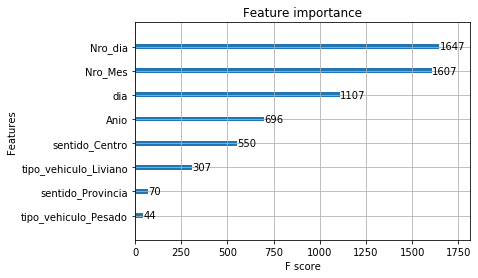

In [35]:
xgb.plot_importance(boost_final)

Predecimos sobre Train y Test

In [36]:
y_train_pred = boost_final.predict(X_train)
y_test_pred = boost_final.predict(X_test)

Calculamos en error

In [37]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 38.34221805254267
RMSE en Test: 38.76344158959899


**Conclusión modelo XGBoost:**

Según el error en train y test vemos que el modelo funciona bien ya que los errores son casi similares, de todos modos el resultado obtenido no es bueno ya que el error es de casi 40 pasos por predicción, estaría por encima de la media que son 25 pasos luego de eliminar los outliers del dataset, pero la desviación es muy grande respecto a la misma, por este motivo creo que planteado de esta manera este modelo no es optimo para series de tiempo.

***Modelo XGBoost para vehículos livianos***

Teniendo en cuenta que según el análisis del Proyecto 3 de la variable tipo_vehiculo ,vemos que esta muy desvalanceada de acuerdo a la cantidad de pasos, ya que la mayoría son vehículos livianos, probamos repetir el modelo XGBoost pero solo teniendo en cuenta estos vehículos. 

In [38]:
dataset.groupby(['tipo_vehiculo']).sum().sort_values(by=['cantidad_pasos'],ascending=False) ['cantidad_pasos']

tipo_vehiculo
Liviano    46338529
Pesado      1527052
Name: cantidad_pasos, dtype: int64

Filtramos el dataset solo para vehículos livianos

In [39]:
dataset_liv=dataset[dataset.tipo_vehiculo =='Liviano']
dataset_liv.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
6,Domingo,Centro,Liviano,23,2017-01-01 00:00:00
11,Domingo,Centro,Liviano,857,2017-01-01 00:00:00
12,Domingo,Centro,Liviano,1,2017-01-01 01:00:00


In [40]:
dataset_liv.describe().round(2)

,cantidad_pasos
count,87348.00
mean,530.50
std,522.05
min,1.00
25%,62.00
50%,300.00
75%,999.00
max,2416.00


In [41]:
dataset_liv = dataset_liv.set_index('fecha')
dataset_liv

,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2017-01-01 00:00:00,Domingo,Provincia,Liviano,9
2017-01-01 00:00:00,Domingo,Provincia,Liviano,644
2017-01-01 00:00:00,Domingo,Centro,Liviano,23
2017-01-01 00:00:00,Domingo,Centro,Liviano,857
2017-01-01 01:00:00,Domingo,Centro,Liviano,1
...,...,...,...,...
2019-12-31 21:00:00,Martes,Centro,Liviano,799
2019-12-31 22:00:00,Martes,Provincia,Liviano,556
2019-12-31 22:00:00,Martes,Centro,Liviano,580


A partir de la fecha agregaos el año, mes y día

In [42]:
dataset_liv['Anio'] = dataset_liv.index.year
dataset_liv['Nro_Mes'] = dataset_liv.index.month
dataset_liv['Nro_dia'] = dataset_liv.index.day
dataset_liv

,dia,sentido,tipo_vehiculo,cantidad_pasos,Anio,Nro_Mes,Nro_dia
fecha,,,,,,,
2017-01-01 00:00:00,Domingo,Provincia,Liviano,9,2017,1,1
2017-01-01 00:00:00,Domingo,Provincia,Liviano,644,2017,1,1
2017-01-01 00:00:00,Domingo,Centro,Liviano,23,2017,1,1
2017-01-01 00:00:00,Domingo,Centro,Liviano,857,2017,1,1
2017-01-01 01:00:00,Domingo,Centro,Liviano,1,2017,1,1
...,...,...,...,...,...,...,...
2019-12-31 21:00:00,Martes,Centro,Liviano,799,2019,12,31
2019-12-31 22:00:00,Martes,Provincia,Liviano,556,2019,12,31
2019-12-31 22:00:00,Martes,Centro,Liviano,580,2019,12,31


Comprobamos si hay valores nulos

In [43]:
dataset_proy4.isnull().sum()

dia                      0
cantidad_pasos           0
Anio                     0
Nro_Mes                  0
Nro_dia                  0
tipo_vehiculo_Liviano    0
tipo_vehiculo_Pesado     0
sentido_Centro           0
sentido_Provincia        0
dtype: int64

Graficamos la variable cantidad de pasos para ver su distribución, outliers etc.

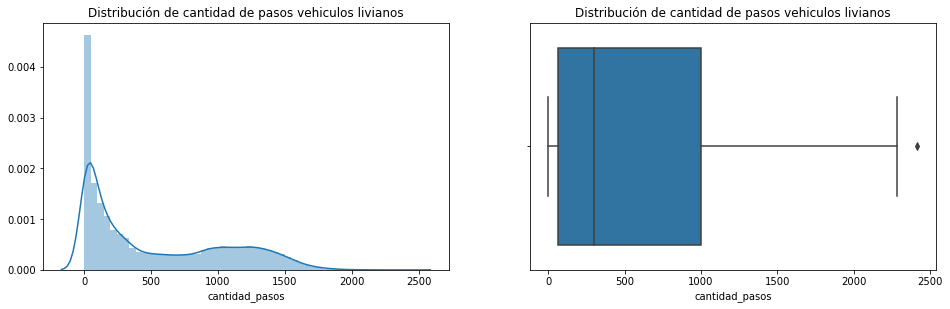

In [44]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_liv['cantidad_pasos'])
plt.title('Distribución de cantidad de pasos vehiculos livianos')

plt.subplot(2,2,2)
sns.boxplot(dataset_liv['cantidad_pasos'])    
plt.title('Distribución de cantidad de pasos vehiculos livianos')

plt.show()

In [45]:
mascara_outliers=eliminar_outliers(dataset_liv,'cantidad_pasos')
mascara_outliers.sum()

1

In [46]:
dataset_liv.cantidad_pasos[mascara_outliers]=np.nan
print(dataset_liv.isna().sum())
dataset_liv = dataset_liv.interpolate(method='time')
print(dataset_liv.isna().sum())

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    1
Anio              0
Nro_Mes           0
Nro_dia           0
dtype: int64
dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
Anio              0
Nro_Mes           0
Nro_dia           0
dtype: int64


Graficamos nuevamente para ver como queda la distribución sin los outliers

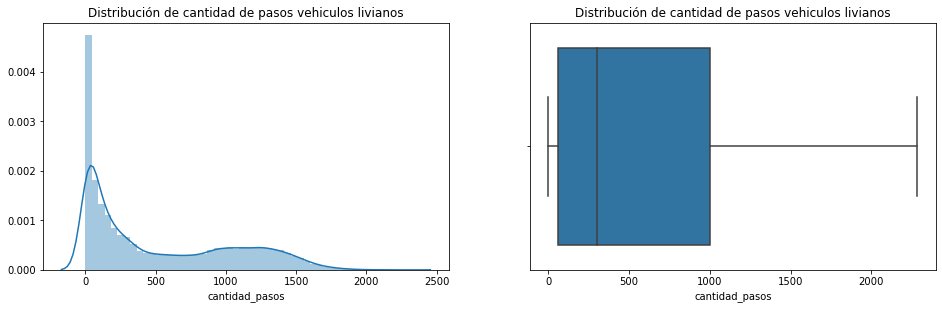

In [47]:
plt.figure(figsize = (16,10))
plt.subplot(2,2,1)
sns.distplot(dataset_liv['cantidad_pasos'])
plt.title('Distribución de cantidad de pasos vehiculos livianos')

plt.subplot(2,2,2)
sns.boxplot(dataset_liv['cantidad_pasos'])    
plt.title('Distribución de cantidad de pasos vehiculos livianos')

plt.show()

In [48]:
dataset_liv.cantidad_pasos.describe().round(2)

count    87348.00
mean       530.49
std        522.01
min          1.00
25%         62.00
50%        300.00
75%        999.00
max       2284.00
Name: cantidad_pasos, dtype: float64

Tranformamos atributos categóricos en información (Encoding), para la variable sentido usaremos OneHotEncoder ya que estas no tienen un orden, en cambio para la variable día si usaremos LabelEncoder. 

Aplicamos la transformación a la varible sentido

In [49]:
la_sentido = LabelEncoder()
sentido_transfor = la_sentido.fit_transform(dataset_liv.sentido)
sentido_transfor_classes = la_sentido.classes_

In [50]:
#Aplicamos OneHotEncoder a la varible sentido
ohe_sentido = OneHotEncoder(sparse=False)
sentido_ohe = ohe_sentido.fit_transform(sentido_transfor.reshape(-1,1))
sentido_ohe.shape

(87348, 2)

In [51]:
#Invoco a la función pdAsigOhe para agregar las columnas al DataFrame
dataset_liv = pdAsigOhe(dataset_liv, 'sentido',sentido_ohe, sentido_transfor_classes)

In [52]:
dataset_liv.drop(columns = ['sentido','tipo_vehiculo'], inplace = True)
dataset_liv

,dia,cantidad_pasos,Anio,Nro_Mes,Nro_dia,sentido_Centro,sentido_Provincia
fecha,,,,,,,
2017-01-01 00:00:00,Domingo,9.0,2017,1,1,0.0,1.0
2017-01-01 00:00:00,Domingo,644.0,2017,1,1,0.0,1.0
2017-01-01 00:00:00,Domingo,23.0,2017,1,1,1.0,0.0
2017-01-01 00:00:00,Domingo,857.0,2017,1,1,1.0,0.0
2017-01-01 01:00:00,Domingo,1.0,2017,1,1,1.0,0.0
...,...,...,...,...,...,...,...
2019-12-31 21:00:00,Martes,799.0,2019,12,31,1.0,0.0
2019-12-31 22:00:00,Martes,556.0,2019,12,31,0.0,1.0
2019-12-31 22:00:00,Martes,580.0,2019,12,31,1.0,0.0


Aplicamos la transformación a la variable días para llevarla a un valor numérico, no usamos LabelEncoder sino que lo hacemos reemplazando.

In [53]:
mappings = {'Domingo':0, 'Lunes':1, 'Martes':2, 'Miércoles':3, 'Jueves':4,'Viernes':5,'Sábado':6}
dataset_liv.dia.replace(mappings, inplace = True)

In [54]:
dataset_liv

,dia,cantidad_pasos,Anio,Nro_Mes,Nro_dia,sentido_Centro,sentido_Provincia
fecha,,,,,,,
2017-01-01 00:00:00,0,9.0,2017,1,1,0.0,1.0
2017-01-01 00:00:00,0,644.0,2017,1,1,0.0,1.0
2017-01-01 00:00:00,0,23.0,2017,1,1,1.0,0.0
2017-01-01 00:00:00,0,857.0,2017,1,1,1.0,0.0
2017-01-01 01:00:00,0,1.0,2017,1,1,1.0,0.0
...,...,...,...,...,...,...,...
2019-12-31 21:00:00,2,799.0,2019,12,31,1.0,0.0
2019-12-31 22:00:00,2,556.0,2019,12,31,0.0,1.0
2019-12-31 22:00:00,2,580.0,2019,12,31,1.0,0.0


Dividimos los datos en train y test

In [55]:
X = dataset_liv.drop("cantidad_pasos", axis=1)
y = dataset_liv.cantidad_pasos

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state = 42)

Definimos parametros iniciales para implementar un modelo XGBoost

In [56]:
parametros_iniciales = {'max_depth': 10, 
            'n_estimators': 100, 
            'objective': 'reg:squarederror', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}   

boost_liv = XGBRegressor(**parametros_iniciales)
boost_liv.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = 50)

[0]	validation_0-rmse:704.358	validation_1-rmse:704.331
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:670.609	validation_1-rmse:670.976
[2]	validation_0-rmse:641.92	validation_1-rmse:642.801
[3]	validation_0-rmse:617.586	validation_1-rmse:619.05
[4]	validation_0-rmse:597.183	validation_1-rmse:599.127
[5]	validation_0-rmse:580.102	validation_1-rmse:582.459
[6]	validation_0-rmse:565.732	validation_1-rmse:568.377
[7]	validation_0-rmse:553.828	validation_1-rmse:556.947
[8]	validation_0-rmse:543.966	validation_1-rmse:547.348
[9]	validation_0-rmse:535.67	validation_1-rmse:539.614
[10]	validation_0-rmse:529.052	validation_1-rmse:533.499
[11]	validation_0-rmse:523.519	validation_1-rmse:528.203
[12]	validation_0-rmse:518.81	validation_1-rmse:524.063
[13]	validation_0-rmse:515.043	validation_1-rmse:520.649
[14]	validation_0-rmse:511.942	validation_1-rmse:517.904


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

Optimizamos los parametros con RandomizedSearchCV

In [57]:
params_grid = {
    'learning_rate': [0.05, 0.1,0,3],
    'subsample': [0.5,0.8],
    'max_depth': np.arange(5,15),
    'gamma': [0,0.8,1]}

boost_opt_liv = RandomizedSearchCV(boost, params_grid, cv = 2) 
boost_opt_liv.fit(X_train, y_train)

# best parameters,
print(boost_opt_liv.best_params_); print(boost_opt_liv.best_score_)

{'subsample': 0.5, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0.8}
0.03761145673373911


Volvemos a entrenar el modelo con los parametros optimizados

In [58]:
parametros_opt = {'max_depth': 5, 
            'n_estimators': 100, # the same as num_rounds in xgboost
            'objective': 'reg:squarederror', 
            'subsample': 0.5, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.05, 
            'seed': 42,
            'gamma': 1,}   

boost_final_liv = XGBRegressor(**parametros_opt)

boost_final_liv.fit(X_train, y_train,eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds = 50)

[0]	validation_0-rmse:723.987	validation_1-rmse:723.743
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:705.444	validation_1-rmse:705.321
[2]	validation_0-rmse:688.391	validation_1-rmse:688.386
[3]	validation_0-rmse:672.521	validation_1-rmse:672.635
[4]	validation_0-rmse:658.051	validation_1-rmse:658.278
[5]	validation_0-rmse:644.541	validation_1-rmse:644.882
[6]	validation_0-rmse:632.105	validation_1-rmse:632.538
[7]	validation_0-rmse:620.645	validation_1-rmse:621.181
[8]	validation_0-rmse:609.999	validation_1-rmse:610.625
[9]	validation_0-rmse:600.35	validation_1-rmse:601.081
[10]	validation_0-rmse:591.938	validation_1-rmse:592.719
[11]	validation_0-rmse:583.812	validation_1-rmse:584.666
[12]	validation_0-rmse:576.348	validation_1-rmse:577.277
[13]	validation_0-rmse:569.439	validation_1-rmse:570.46
[14]	validation_0-rmse:563.17	validation_1-rmse:564.257

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85, gamma=1,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.5, verbosity=1)

*¿Que variables toman mas importancia para el modelo?*

Según el gráfico, vemos que toma mas relevancia el numero de día y luego el mes, y por el contrario el tipo de vehiculo y sentido no son tan relevantes.

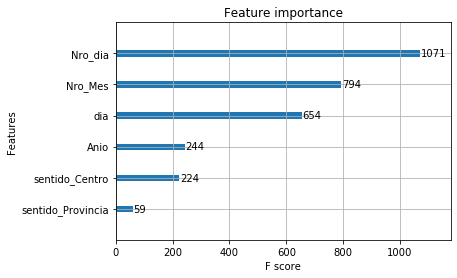

In [59]:
xgb.plot_importance(boost_final_liv)

Predecimos sobre Train y Test

In [60]:
y_train_pred = boost_final_liv.predict(X_train)
y_test_pred = boost_final_liv.predict(X_test)

Calculamos en error

In [61]:
MSE = mean_squared_error(y_train, y_train_pred)
print('RMSE en Train:',np.sqrt(MSE))

MSE = mean_squared_error(y_test, y_test_pred)
print('RMSE en Test:',np.sqrt(MSE))

RMSE en Train: 500.32040604740973
RMSE en Test: 503.60801039889293


**Conclusión modelo XGBoost vehiculos livianos:**

Al igual que en el modelo anterior contando ambos tipos de vehículos, el resultado obtenido no es bueno ya que el error es de casi 500 pasos por predicción, algo menos que la media que son 530 pasos, en este caso tambien la desviación es muy grande, por este motivo creo que planteado de esta manera tampoco este modelo no es optimo para series de tiempo.


### Prophet

***Utilizamos Propeth para predecir el último trimestre del 2019***

Retomamos el dataset "dataset" para hacer el resampleo por día, repetimos los pasos del punto anterior para buscar outliers e interpolar

In [62]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


In [63]:
diario.describe().round(2)

,cantidad_pasos
count,1095.00
mean,43712.86
std,8192.74
min,0.00
25%,39061.50
50%,43761.00
75%,49498.00
max,63127.00


Graficamos la serie

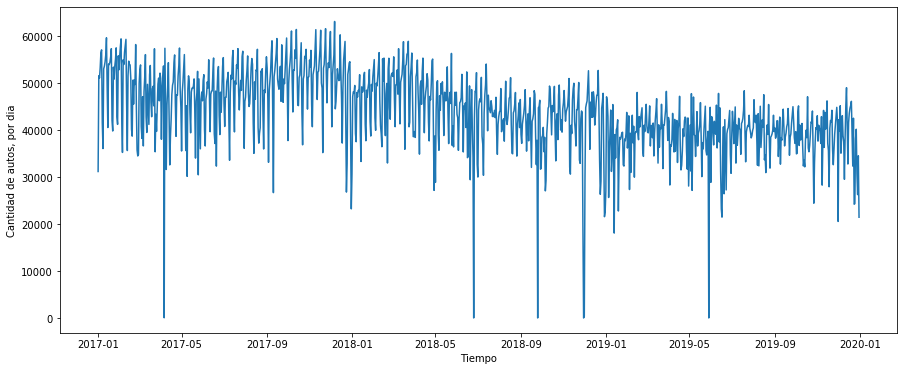

In [64]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Llamamos a la función para buscar los outliers y procedemos a interpolar

In [65]:
mascara_outliers=eliminar_outliers(diario,'cantidad_pasos')
mascara_outliers.sum()

16

In [66]:
#Analizamos los outliers obtenidos
dataset_outliers=diario[mascara_outliers]
dataset_outliers.sort_values('cantidad_pasos')

,cantidad_pasos
fecha,
2018-06-25,0
2018-09-25,0
2018-11-30,0
2019-05-29,0
2017-04-06,40
2018-12-01,350
2019-01-13,18076
2018-11-29,19728
2019-12-01,20553


Rellenamos los valores con nan y luego interpolamos la serie

In [67]:
diario.cantidad_pasos[mascara_outliers]=np.nan
print(diario.isna().sum())
diario = diario.interpolate(method='time')
print(diario.isna().sum())

cantidad_pasos    16
dtype: int64
cantidad_pasos    0
dtype: int64


Graficamos nuevamente la serie luego de interpolar

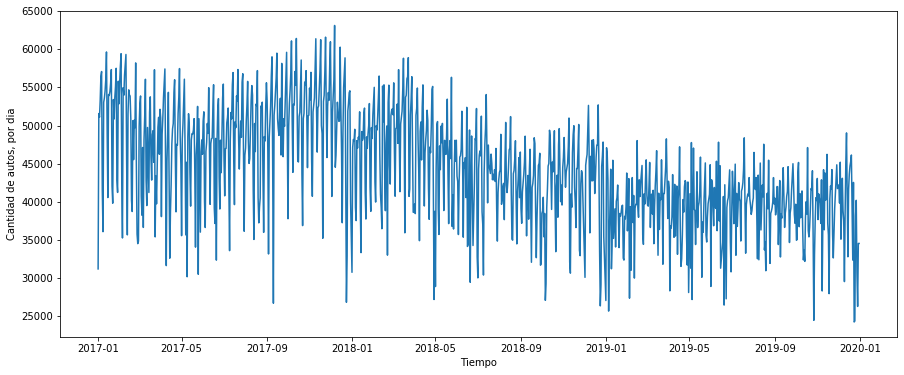

In [68]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Dejamos afuera los últimos 3 meses que vamos a predecir y agregamos una columna con el día para luego transformarlo al formato que necesitamos para Prophet

In [69]:
dataset_predic = diario.iloc[:1003]
dataset_predic.insert(0, 'dia', dataset_predic.index)
dataset_predic

,dia,cantidad_pasos
fecha,,
2017-01-01,2017-01-01,31183.0
2017-01-02,2017-01-02,51568.0
2017-01-03,2017-01-03,51093.0
2017-01-04,2017-01-04,53332.0
2017-01-05,2017-01-05,56486.0
...,...,...
2019-09-26,2019-09-26,43110.0
2019-09-27,2019-09-27,44985.0
2019-09-28,2019-09-28,41925.0


Convertimos el dataset según los nombre específicos que usa Prophet

In [70]:
serie_dias = dataset_predic.rename(columns = {'dia': 'ds','cantidad_pasos': 'y'})
serie_dias.head()

,ds,y
fecha,,
2017-01-01,2017-01-01,31183.0
2017-01-02,2017-01-02,51568.0
2017-01-03,2017-01-03,51093.0
2017-01-04,2017-01-04,53332.0
2017-01-05,2017-01-05,56486.0


Entrenamos el modelo

In [71]:
my_model = Prophet(daily_seasonality=False, weekly_seasonality=False)
my_model.fit(serie_dias)

Definimos el future_dates que vamos a predecir, en este caso son 92 días porque es el último trimestre del 2019

In [72]:
future_dates = my_model.make_future_dataframe(periods = 92)
future_dates.tail(5)

,ds
1090,2019-12-27
1091,2019-12-28
1092,2019-12-29
1093,2019-12-30
1094,2019-12-31


Predecimos

In [73]:
forecast = my_model.predict(future_dates)
# predecimos para el próximo trimestre
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
1088,2019-12-25,37975.355203,30809.637504,45443.671975
1089,2019-12-26,37682.074191,30158.955045,45260.611392
1090,2019-12-27,37412.379602,29419.823321,44823.029674
1091,2019-12-28,37169.220503,29878.076740,45436.834632
1092,2019-12-29,36955.040841,29551.170130,44399.777812
1093,2019-12-30,36771.744968,29421.387931,44309.335749
1094,2019-12-31,36620.675360,29348.550816,43624.121394


Graficamos las predicciones

In [74]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

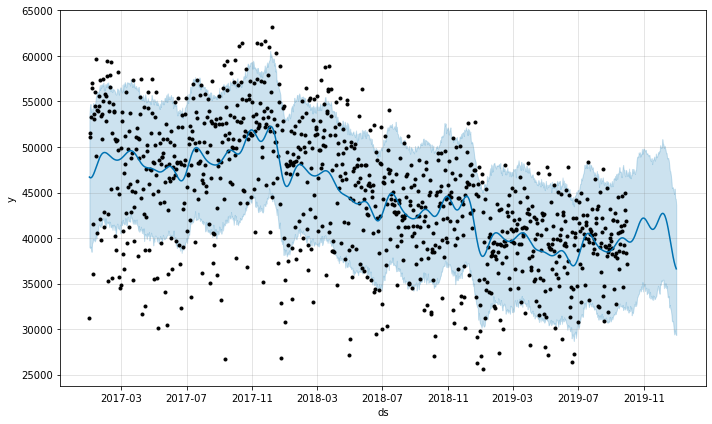

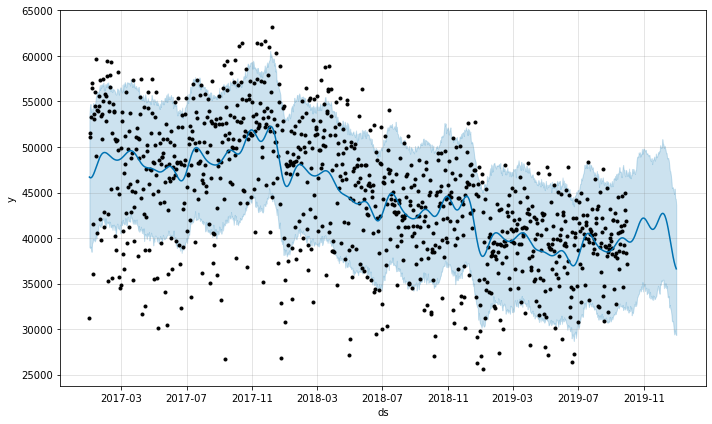

In [75]:
my_model.plot(forecast)

Graficamos los componentes de los pronosticos

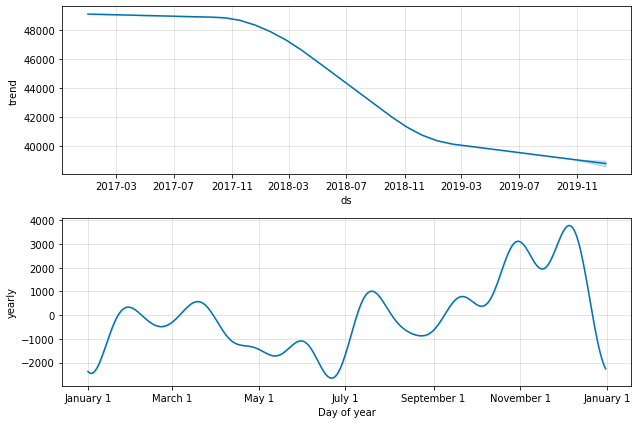

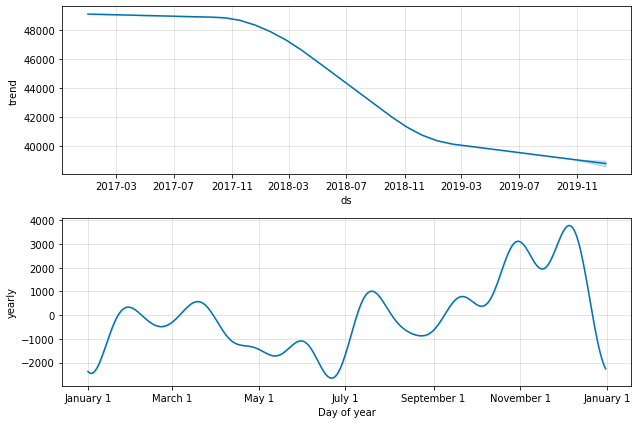

In [76]:
my_model.plot_components(forecast)

Para evaluar las métricas de error creamos un nuevo dataset con las predicciones y el valor original de la serie

Buscamos los últimos 3 meses del forecast

In [77]:
predict_trim=fc.iloc[973:1065]
predict_trim

,ds,yhat
973,2019-09-01,38655.903600
974,2019-09-02,38711.395581
975,2019-09-03,38774.436283
976,2019-09-04,38844.587866
977,2019-09-05,38921.218266
...,...,...
1060,2019-11-27,41854.892253
1061,2019-11-28,42002.069119
1062,2019-11-29,42145.667470
1063,2019-11-30,42281.467443


Buscamos los últimos 3 trimestres del dataset diario y unimos con el de las predicciones

In [78]:
ult_trim=diario.iloc[973:1065]
ult_trim.fecha=ult_trim.insert(0, 'dia', ult_trim.index)
ult_trim

,dia,cantidad_pasos
fecha,,
2019-09-01,2019-09-01,40473.0
2019-09-02,2019-09-02,38274.0
2019-09-03,2019-09-03,38869.0
2019-09-04,2019-09-04,41994.0
2019-09-05,2019-09-05,41954.0
...,...,...
2019-11-27,2019-11-27,41133.0
2019-11-28,2019-11-28,43130.0
2019-11-29,2019-11-29,44841.0


In [79]:
metric_df = predict_trim.set_index('ds')[['yhat']].join(ult_trim.set_index('dia').cantidad_pasos).reset_index()
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,cantidad_pasos
87,2019-11-27,41854.892253,41133.0
88,2019-11-28,42002.069119,43130.0
89,2019-11-29,42145.667470,44841.0
90,2019-11-30,42281.467443,41722.0
91,2019-12-01,42405.275294,41968.5


Calculamos el RMSE y MAPE

In [80]:
mse_prophet=mean_squared_error(metric_df.cantidad_pasos, metric_df.yhat)
rmse = np.sqrt(mse_prophet)
print(rmse)

4456.765107729481


In [81]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [82]:
print('MAPE: ',mape(metric_df.cantidad_pasos, metric_df.yhat))

MAPE:  9.251460714820219


Utilizamos la funcionalidad que incluye Prophet de la validación cruzada de series de tiempo para medir el error de los  pronósticos.

In [83]:
#Initial: dejamos 2 años para entrenamiento
#Horizon: usamos 90 días para validación.

df_cv = cross_validation(my_model, initial='730 days', period='45 days', horizon = '90 days')
df_cv.tail()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-03 00:00:00 and 2019-07-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
445,2019-09-26,37740.680645,29688.914049,45449.482540,43110.0,2019-07-02
446,2019-09-27,37689.953200,30203.846621,45169.905199,44985.0,2019-07-02
447,2019-09-28,37636.188489,30393.617815,45288.763501,41925.0,2019-07-02
448,2019-09-29,37581.498748,29960.488091,45364.178289,38348.0,2019-07-02
449,2019-09-30,37528.109179,29426.368635,44512.699221,37170.0,2019-07-02


Evaluamos metricas de error

In [84]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,2.217418e+07,4708.946367,3830.066772,0.099050,0.089567,0.933333
1,10 days,2.145943e+07,4632.431867,3736.495744,0.095701,0.083207,0.933333
2,11 days,2.088909e+07,4570.458315,3781.974136,0.092957,0.089567,0.933333
3,12 days,2.202922e+07,4693.529070,4016.687742,0.099501,0.099214,0.933333
4,13 days,2.136520e+07,4622.250655,3908.984723,0.097150,0.097997,0.911111
...,...,...,...,...,...,...,...
77,86 days,4.292587e+07,6551.783735,5811.908519,0.143593,0.151978,0.777778
78,87 days,4.171723e+07,6458.887983,5655.187875,0.138224,0.150403,0.800000
79,88 days,3.817347e+07,6178.468125,5471.557741,0.135211,0.150403,0.822222
80,89 days,4.180921e+07,6466.003979,5671.626919,0.138485,0.140610,0.800000


Graficamos las métricas RMSE y MAPE

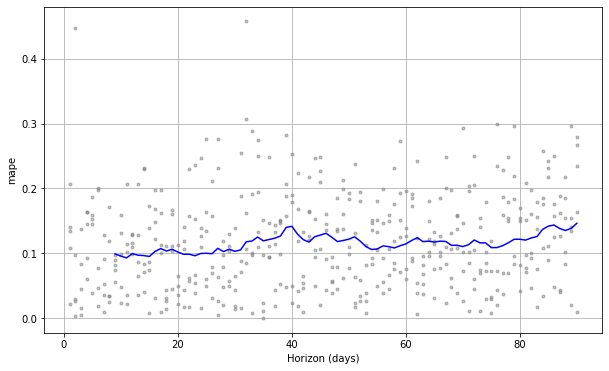

In [85]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

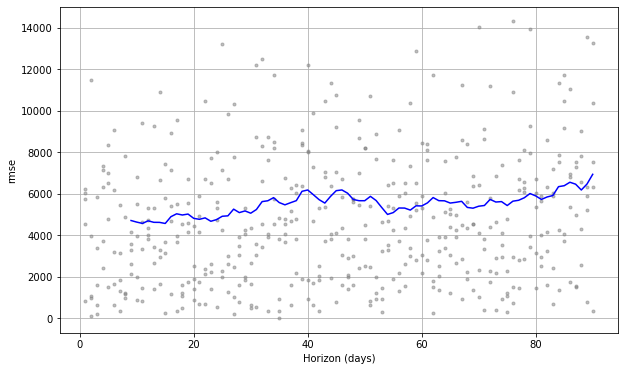

In [86]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Observando los gráficos vemos que la linea azul que representa la métrica, estaría en un promedio de alrededor del 10% (MAPE) y 5000 (RSME), apenas un poco superior a lo que evaluamos comparando las predicciones contra el último trimestre en el punto anterior.

Probamos optimizar los hiperparametros para ver si logramos mejor rendimiento del modelo

In [87]:
#Definimos manualmente los cortes según los parámetros usados en el punto anterior
cutoffs= pd.to_datetime(df_cv.cutoff.unique())
cutoffs

DatetimeIndex(['2019-01-03', '2019-02-17', '2019-04-03', '2019-05-18',
               '2019-07-02'],
              dtype='datetime64[ns]', freq=None)

In [88]:

import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.95],
       
}

# Generamos todas las combinaciones de parametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # 

# Usamos cross validation para evaluar todos los parametros
for params in all_params:
    m = Prophet(**params,weekly_seasonality=False,daily_seasonality=False).fit(serie_dias)
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EF3288>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EE4B48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EAFF88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23F67248>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EB4988>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EAF488>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EE4148>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001DF23EDF148>
INFO:fbprophet:Applying in parallel with <concur

    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01               0.80   
1                     0.001                     0.01               0.95   
2                     0.001                     0.10               0.80   
3                     0.001                     0.10               0.95   
4                     0.001                     1.00               0.80   
5                     0.001                     1.00               0.95   
6                     0.001                    10.00               0.80   
7                     0.001                    10.00               0.95   
8                     0.010                     0.01               0.80   
9                     0.010                     0.01               0.95   
10                    0.010                     0.10               0.80   
11                    0.010                     0.10               0.95   
12                    0.0

In [89]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'changepoint_range': 0.95}


Como se puede observar según la mejor combinación de parámetros el mínimo error obtenido es 4480 en la corrida 27, lo cual no difiere demasiado del primer modelo corrido con el cual se obtuvo un rmse de 4456 comparando las predicciones contra los valores reales del último trimestre del 2019.

**Conclusión implementación Prophet para predecir el último trimestre del 2019:**
    
La implementación de este modelo mejora levemente los resultados obtenidos en el Proyecto 3 con Randon Forest, donde el (MAPE)
error porcentual absoluto medio superaba el 10%, y el RSME se acercaba a los 5000.    

***Utilizamos Prophet para prediccion el año 2020***

Copiamos el dataset resampleado a días tomando los 3 años

In [90]:
dataset_predic_2020 = diario.copy()
dataset_predic_2020

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


Hacemos las transformaciones necesarias para poder usar Prophet

In [91]:
dataset_predic_2020.insert(0, 'dia', dataset_predic_2020.index)
dataset_predic_2020

,dia,cantidad_pasos
fecha,,
2017-01-01,2017-01-01,31183.0
2017-01-02,2017-01-02,51568.0
2017-01-03,2017-01-03,51093.0
2017-01-04,2017-01-04,53332.0
2017-01-05,2017-01-05,56486.0
...,...,...
2019-12-27,2019-12-27,40182.0
2019-12-28,2019-12-28,30681.0
2019-12-29,2019-12-29,26259.0


In [92]:
dataset_predic_2020 = dataset_predic_2020.rename(columns = {'dia': 'ds','cantidad_pasos': 'y'})
dataset_predic_2020.head()

,ds,y
fecha,,
2017-01-01,2017-01-01,31183.0
2017-01-02,2017-01-02,51568.0
2017-01-03,2017-01-03,51093.0
2017-01-04,2017-01-04,53332.0
2017-01-05,2017-01-05,56486.0


Entrenamos el modelo

In [93]:
my_model_2020 = Prophet(daily_seasonality=False,weekly_seasonality=False)
my_model_2020.fit(dataset_predic_2020)

Creamos el dataset para el año 2020 que vamos a predecir

In [94]:
future_dates_2020 = my_model_2020.make_future_dataframe(periods = 365)
future_dates_2020.tail(5)

,ds
1455,2020-12-26
1456,2020-12-27
1457,2020-12-28
1458,2020-12-29
1459,2020-12-30


In [95]:
forecast_2020 = my_model_2020.predict(future_dates_2020)
# predecimos para el próximo año
forecast_2020[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
1450,2020-12-21,33725.202127,26453.774672,41451.155790
1451,2020-12-22,33352.192045,25718.060719,41805.535119
1452,2020-12-23,32989.925417,26176.279969,40880.896072
1453,2020-12-24,32643.205098,25072.999576,40495.510423
1454,2020-12-25,32316.526664,24781.540496,40307.620356
1455,2020-12-26,32013.993743,24884.978603,39335.349587
1456,2020-12-27,31739.242915,24121.038990,39071.104248
1457,2020-12-28,31495.379756,24071.527150,39343.274054
1458,2020-12-29,31284.927275,23857.405449,39469.721138
1459,2020-12-30,31109.787693,23913.949822,38934.302054


Graficamos las predicciones

In [96]:
fc_2020 = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

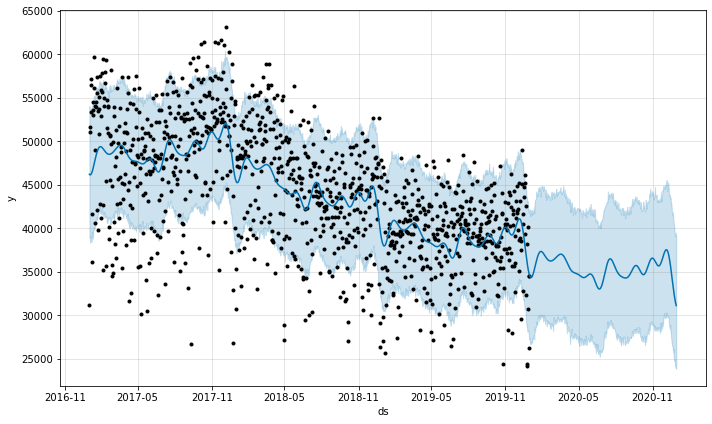

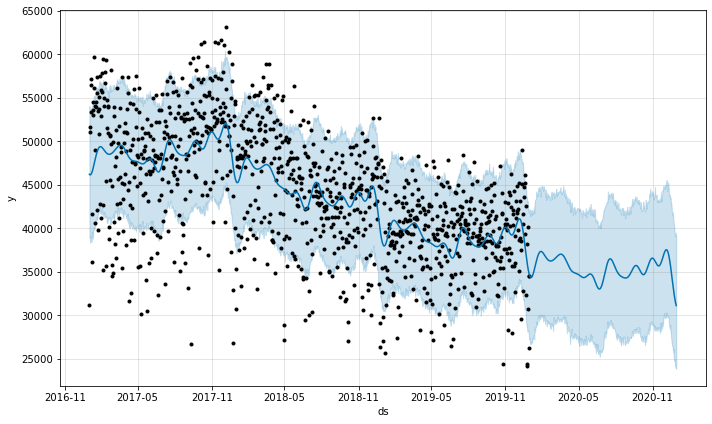

In [97]:
my_model_2020.plot(forecast_2020)

Graficamos los componentes de las predicciones

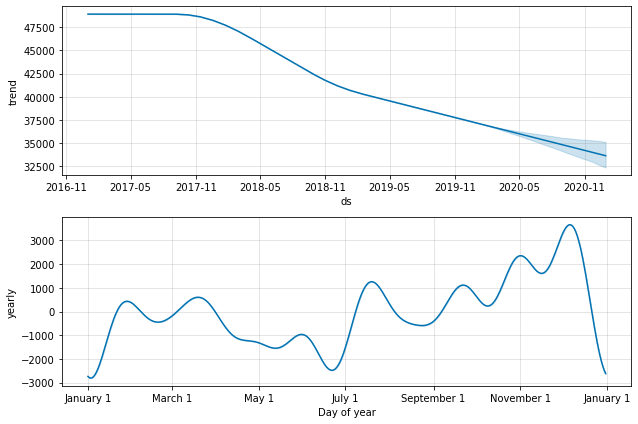

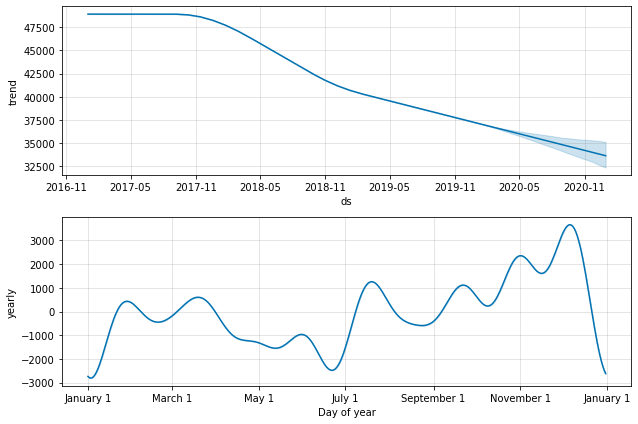

In [98]:
my_model_2020.plot_components(forecast_2020)

Al igual que en la prediccion para el trimestre del 2019 creamos un nuevo dataset con las predicciones y los valores originales

In [99]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')

In [100]:
data_2020

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
0,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Centro,24
1,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Efectivo,Efectivo,Provincia,80
2,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en Infracción,Provincia,1
3,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Centro,1
4,2020,2020-01-01 00:00:00,enero,Miércoles,1,0,1,ALBERDI,Auto,Rec.Deuda,Paso en infracción con Multa LPR,Provincia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628076,2020,2020-08-31,agosto,Lunes,31,23,0,PB1,Pesados 6 Ejes,Tag,Tag - PosPago,Provincia,17
1628077,2020,2020-08-31,agosto,Lunes,31,23,0,PB1,Pesados 6 Ejes,Violación,Violación - Normal,Provincia,2
1628078,2020,2020-08-31,agosto,Lunes,31,23,0,PB4,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,24
1628079,2020,2020-08-31,agosto,Lunes,31,23,0,PB4,Pesados 6 Ejes,Tag,Tag - PosPago OCR,Centro,1


In [101]:
mask_2020 = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
data_2020 = data_2020[mask_2020]

In [102]:
data_2020['fecha2'] = pd.to_datetime(data_2020.fecha) + pd.to_timedelta(data_2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
data_2020.drop(columns=['fecha','hora_fin'], inplace = True)

data_2020.head()

,periodo,mes,dia,dia_fecha,hora_inicio,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha2
52,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Centro,326,2020-01-01 01:00:00
53,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319,2020-01-01 01:00:00
134,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Centro,199,2020-01-01 02:00:00
135,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Provincia,180,2020-01-01 02:00:00
202,2020,enero,Miércoles,1,2,ILLIA,Auto,Efectivo,Efectivo,Centro,114,2020-01-01 03:00:00


In [103]:
#Cambiamos el nombre de fecha2 a fecha
data_2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
data_2020.head()

,periodo,mes,dia,dia_fecha,hora_inicio,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos,fecha
52,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Centro,326,2020-01-01 01:00:00
53,2020,enero,Miércoles,1,0,ILLIA,Auto,Efectivo,Efectivo,Provincia,319,2020-01-01 01:00:00
134,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Centro,199,2020-01-01 02:00:00
135,2020,enero,Miércoles,1,1,ILLIA,Auto,Efectivo,Efectivo,Provincia,180,2020-01-01 02:00:00
202,2020,enero,Miércoles,1,2,ILLIA,Auto,Efectivo,Efectivo,Centro,114,2020-01-01 03:00:00


In [104]:
diario_2020 = data_2020.resample('D', on = 'fecha').sum()
diario_2020.drop(columns = ['periodo','hora_inicio','dia_fecha'], inplace = True)
print(diario_2020.shape)
diario_2020.head()

(244, 1)


,cantidad_pasos
fecha,
2020-01-01,21395
2020-01-02,33722
2020-01-03,37067
2020-01-04,30627
2020-01-05,27812


Graficamos como quedaría la serie resampleada

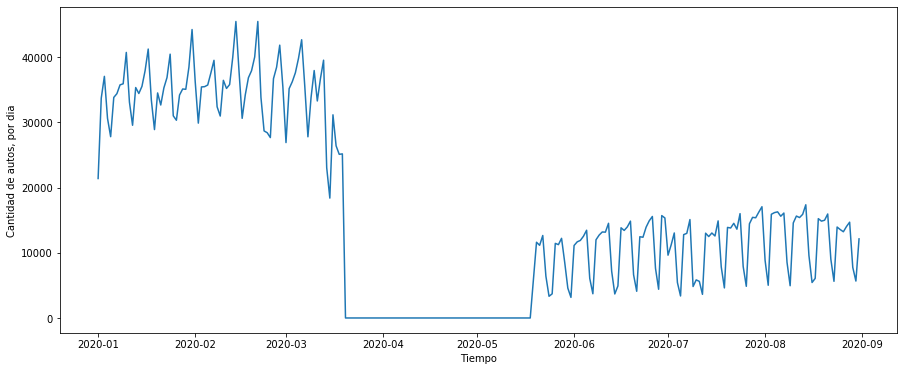

In [105]:
plt.figure(figsize = (15,6))
plt.plot(diario_2020.index, diario_2020.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Graficamos la serie completa para ver como se comporta el 2020 con respecto al año anterior

In [106]:
serie_ext = pd.concat([diario,diario_2020])

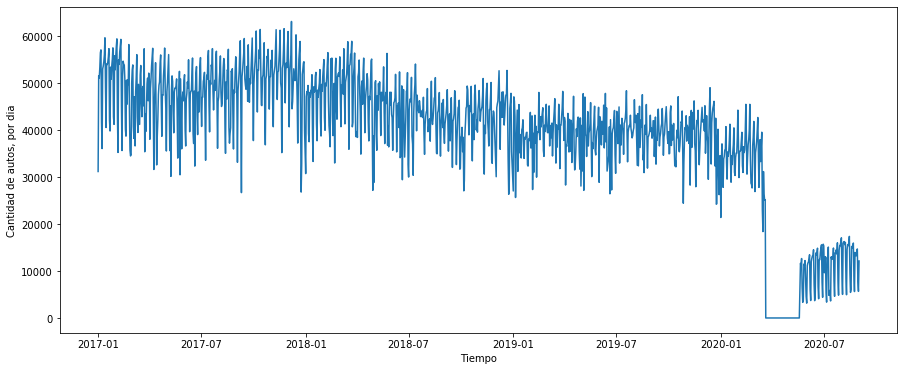

In [107]:
plt.figure(figsize = (15,6))
plt.plot(serie_ext.index, serie_ext.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [108]:
diario_2020.insert(0, 'dia', diario_2020.index)
diario_2020

,dia,cantidad_pasos
fecha,,
2020-01-01,2020-01-01,21395
2020-01-02,2020-01-02,33722
2020-01-03,2020-01-03,37067
2020-01-04,2020-01-04,30627
2020-01-05,2020-01-05,27812
...,...,...
2020-08-27,2020-08-27,14034
2020-08-28,2020-08-28,14696
2020-08-29,2020-08-29,7767


In [109]:
metric_df_2020 = forecast_2020.set_index('ds')[['yhat']].join(diario_2020.set_index('dia').cantidad_pasos).reset_index()
metric_df_2020.dropna(inplace=True)
metric_df_2020

,ds,yhat,cantidad_pasos
1095,2020-01-01,34495.334274,21395.0
1096,2020-01-02,34403.247301,33722.0
1097,2020-01-03,34348.171120,37067.0
1098,2020-01-04,34329.269328,30627.0
1099,2020-01-05,34345.112523,27812.0
...,...,...,...
1334,2020-08-27,34275.438315,14034.0
1335,2020-08-28,34284.742448,14696.0
1336,2020-08-29,34300.559381,7767.0
1337,2020-08-30,34323.471721,5663.0


Como ya sabemos el 2020 es un año atipico por la pandemia por lo que es imposible predecir con datos de años anteriores, por este motivo vamos a calcular el error tomando solamente los días hasta que empezó la cuarentena (18 de Marzo).

In [110]:
metric_df_2020=metric_df_2020.iloc[:78]
metric_df_2020

,ds,yhat,cantidad_pasos
1095,2020-01-01,34495.334274,21395.0
1096,2020-01-02,34403.247301,33722.0
1097,2020-01-03,34348.171120,37067.0
1098,2020-01-04,34329.269328,30627.0
1099,2020-01-05,34345.112523,27812.0
...,...,...,...
1168,2020-03-14,36954.546133,23052.0
1169,2020-03-15,36979.417773,18390.0
1170,2020-03-16,36998.029688,31168.0
1171,2020-03-17,37009.689386,26407.0


Calculamos el RMSE y MAPE

In [111]:
mse_prophet=mean_squared_error(metric_df_2020.cantidad_pasos, metric_df_2020.yhat)
rmse = np.sqrt(mse_prophet)
print(rmse)

5396.119843311778


In [112]:
mape(metric_df_2020.cantidad_pasos, metric_df_2020.yhat)

13.058133656361626

**Conclusión implementación Prophet para predecir el año 2020**

En este caso para el intervalo de tiempo en el cual se analizan las predicciones vemos que no tiene la misma performance que el modelo para el último trimestre, de todos modos es aceptable ya que tiene un error del 13%, similar a lo obtenido con Random Forest en test para el proyecto 3

### Conclusión final

Con respecto a XGBoost, mas allá del modelo implementado, no esperaba grandes resultados haciendo predicciones con todas las varialbes, mas que nada porque al ser una serie de tiempo me resulto mas directo y sencillo implementar modelos que predigan directamente sobre series resampleadas, en este caso a días.

De acuerdo a lo que esperaba de Prophet mejoró la prediccion con respecto al modelo Randon Forest implementado en el Proyecto 3, a grandes rasgos podemos ver que se mejora en alrededor de 500 pasos y baja un 1% el error porcentual, si bien la mejora no es tan grande considero mas óptimo este tipo de modelos por su simplicidad para implementar y justamente por lo que se expresó en el proyecto 3, son modelos específicos para series de tiempo